In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import os
import time
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from collections import namedtuple
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from data.othello import Othello, OthelloBoardState, permit, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.model import GPT, GPTConfig, GPTforProbing, GPTforProbeIA
from mingpt.probe_trainer import Trainer, TrainerConfig
from mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer

## Evaluating linear board probes

In [102]:
layer = 6
model_ckpt = "playertype/playertype_e40"

In [103]:
othello = Othello(data_root="othello_synthetic", n_games=10000, deduplicate=False, test_split=0)

# player_types, games = zip(*othello)
train_dataset = CharDataset(othello)

mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbing(mconf, probe_layer=layer)
load_res = model.load_state_dict(torch.load(f"./ckpts/{model_ckpt}.ckpt"))


if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 5.036 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 10000 for training, 0 for validation
Dataset created has 10000 sequences, 61 unique words.


In [104]:
# creating dataset of activations and properties
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
act_container = []
property_container = []

for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
    # truncates game if it is less than 60 moves
    valid_until = tbf.index(-100) if -100 in tbf else 999

    properties = []
    ob = OthelloBoardState()
    for i, move in enumerate(tbf[:valid_until]):
        ob.update([move])

        # flipping states so always from moving player's perspective
        fixed_state = np.array(ob.get_state())
        if ob.get_next_hand_color() == 1:
            fixed_state = 2 - fixed_state
        properties.append(fixed_state)
    property_container.extend(properties)

    # gets activations for each move
    act = model(x.to(device))[0, ...].detach().cpu()  # [block_size, f]
    act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
    act_container.extend(act)

    assert len(act_container) == len(property_container)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-104-9a1f5b2ebd71>:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
<ipython-input-104-9a1f5b2ebd71>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
100%|██████████| 10000/10000 

In [105]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"{len(act)} pairs loaded...")
        self.act = act
        self.y = y
        # print(np.sum(np.array(y)==0), np.sum(np.array(y)==1), np.sum(np.array(y)==2))
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    def __getitem__(self, idx):
        return self.act[idx], torch.tensor(self.y[idx]).to(torch.long)

probing_dataset = ProbingDataset(act_container, property_container)

probe_loader = DataLoader(probing_dataset, shuffle=False, pin_memory=True, batch_size=128, num_workers=1)

589847 pairs loaded...
y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


In [109]:
probe = BatteryProbeClassification(device, probe_class=3, num_task=64)
load_res = probe.load_state_dict(torch.load(f"./ckpts/playertype/probes/state/layer{layer}/checkpoint.ckpt"))

probe = probe.to(device)

In [110]:
total_games = 0
total_correct = np.zeros(64)

pbar = tqdm(probe_loader, total=len(probe_loader))
for x, y in pbar:
    x = x.to(device)  # [B, f]
    y = y.to(device)  # [B, #task=64] 

    logits, loss = probe(x, y)
    pred = torch.argmax(logits, dim=2)

    correct = torch.sum(pred == y, dim=0)
    correct = correct.detach().cpu().numpy()
    np.add(total_correct, correct, out=total_correct)

    total_games += x.shape[0]

    pbar.set_description(f"{sum(total_correct) / (total_games * 64):.5f}% correct")

print(total_games)
print(total_correct)

  0%|          | 0/4609 [00:00<?, ?it/s]

0.92860% correct: 100%|██████████| 4609/4609 [00:09<00:00, 479.37it/s]

589847
[560094. 539711. 531611. 536414. 533846. 538513. 545360. 558953. 558844.
 554628. 546029. 543905. 543352. 548881. 558036. 568260. 565758. 551319.
 544405. 537992. 540366. 546504. 554953. 571441. 564796. 547481. 536770.
 528683. 528831. 539504. 549221. 567444. 566392. 548435. 538649. 527555.
 528616. 537711. 546227. 565902. 568334. 553851. 545231. 537543. 535396.
 544900. 551827. 566081. 562936. 557727. 548597. 541903. 542976. 547590.
 552370. 562761. 559869. 543915. 538111. 532506. 531110. 532474. 539784.
 555482.]


<AxesSubplot:>

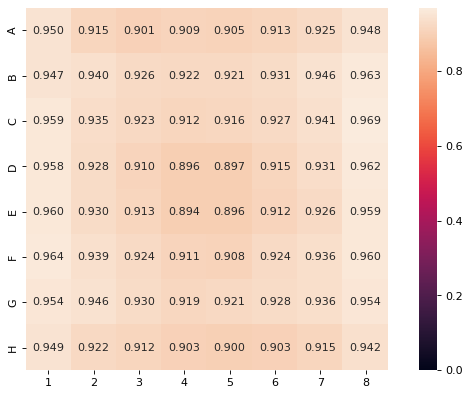

In [111]:
import seaborn as sns

avg = total_correct / total_games
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(avg.reshape(8, 8), vmin=0,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".3f")

## Linear board interventions

### utils

In [4]:
def draw_board_heatmap(board, **kwargs):
    fig = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8), **kwargs,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".3f")
    return fig

In [5]:
def draw_heatmap_from_tokens(token_pred, **kwargs):
    # take off first token, as it isn't a board position
    token_pred = token_pred[1:]
    # add padding to get from tokens -> board positions
    padding = np.zeros(2)
    board = np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)
    # plotting
    return draw_board_heatmap(board, **kwargs)

In [6]:
def load_linear_probes(ckpt_path, layer_range, probe_class=3, num_task=64):
    probes = {}
    for layer in layer_range:
        p = BatteryProbeClassification(torch.cuda.current_device(), probe_class=probe_class, num_task=num_task)
        load_res = p.load_state_dict(torch.load(f"./ckpts/{ckpt_path}/layer{layer}/checkpoint.ckpt"))
        p.eval()
        probes[layer] = p
    return probes

In [7]:
def load_model_layers(ckpt_path, layer_range):
    mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)

    models = {}
    for layer in layer_range:
        model = GPTforProbeIA(mconf, probe_layer=layer)
        # model = GPT(mconf)
        load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt_path}.ckpt"))
        if torch.cuda.is_available():
            device = torch.cuda.current_device()
            model = model.to(device)
        _ = model.eval()
        models[layer] = model

    return models, device

In [8]:
def get_probe_logits(models, device, probes, layer, completion, softmax=False):
    p = probes[layer]
    
    partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)
    whole_mid_act = models[layer].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
    mid_act = whole_mid_act[0, -1]
    logits = p(mid_act[None, :])[0].squeeze(0)  # [num_task, probe_class]

    if softmax:
        logits = torch.softmax(logits, dim=-1)

    return logits.detach().cpu().numpy()

In [9]:
def get_probe_board_state(probe, act):
    logits = probe(act[None, :])[0].squeeze(0)  # [64, 3]
    labels = logits.detach().argmax(dim=-1)
    # print(labels)

    ob = OthelloBoardState()
    ob.state = labels.reshape((8, 8)) - 1
    return ob

In [10]:
def intervene(models, device, probes, completion, i_layers, desired_probe_state=None, scale=1):
    all_layers = range(1, 9)

    partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)
    pre_intv_pred, _ = models[all_layers.stop-1](partial_game[None, :])  # [B, T, F=512]
    pre_intv_pred = pre_intv_pred[0, -1, :].detach().cpu().numpy()

    # tracking probes across the intervention
    saved_probe_logits = []

    for i, current_layer in enumerate(all_layers):
        p = probes[current_layer]

        if i == 0:
            whole_mid_act = models[all_layers.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
        # after starting layer, use forward_2nd_stage to get to next layer
        else:
            whole_mid_act = models[all_layers.start].forward_2nd_stage(whole_mid_act, current_layer-1, current_layer)[0]  # [1, T, F=512]

        # cut out most recent features and check probe prediction
        mid_act = whole_mid_act[0, -1]
        pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
        saved_probe_logits.append(pre_intv_logits)

        if current_layer not in i_layers:
            continue

        # make actual intervention on mid activations
        new_mid_act = mid_act.clone()

        # linear intervention (simple steering vector)
        # m = p.proj.weight.data.reshape((64, 3, -1))  # [64, 3, 512]
        # for bi in intvs:
        #     new_mid_act += m[permit(bi.pos), bi.end] * scale
        #     new_mid_act -= m[permit(bi.pos), bi.start] * scale

        # linear intervention (adding proj inverse of goal state)
        pinv = torch.pinverse(p.proj.weight.data)  # [512, 192]
        desired_probe_tensor = torch.from_numpy(desired_probe_state).to(pinv.dtype).to(device)
        new_mid_act = torch.matmul(pinv, desired_probe_tensor.reshape(192))

        # swap in 
        whole_mid_act[0, -1] = new_mid_act

    post_intv_pred, _ = models[all_layers.start].predict(whole_mid_act)
    post_intv_pred = post_intv_pred[0, -1, :].detach().cpu().numpy()

    saved_probe_logits = np.array([x.detach().cpu().numpy() for x in saved_probe_logits])
    return pre_intv_pred, post_intv_pred, saved_probe_logits

### matrix board state intervention

In [8]:
all_layers = range(1, 9)
models, device = load_model_layers("bias/TLcontrol", all_layers)
probes = load_linear_probes("bias/probes/state_control", all_layers)

In [9]:
othello = Othello(data_root="othello_synthetic", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)

Mem Used: 3.914 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


In [120]:
game_index = 0
completion = othello[game_index][:31]

pre_board = OthelloBoardState()
pre_board.update(completion)
print("next color:", pre_board.get_next_hand_color())
pre_board.__print__()
print([permit_reverse(x) for x in pre_board.get_valid_moves()])

next color: 0
--------------------
['f5', 'f4', 'g3', 'd6', 'c7', 'f6', 'c5', 'g4', 'h3', 'b6', 'f3', 'g5', 'd3', 'd8', 'e6', 'g2', 'b4', 'b5', 'g7', 'd2', 'c3', 'a5', 'd1', 'e3', 'h1', 'e1', 'a3', 'g1', 'g6', 'd7', 'f1']
a     X   O      
b       X O O    
c     O   X   O  
d X O O O O O O O
e X   O X X O    
f X   X O O X    
g X X O O O X X  
h X   X          
  1 2 3 4 5 6 7 8
--------------------
['b3', 'e2', 'e7', 'f2', 'f7', 'g8', 'h6', 'h7', 'h8']


In [121]:
partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)

pre_intv_pred, _ = models[all_layers.stop-1](partial_game[None, :])  # [B, T, F=512]
pre_intv_pred = pre_intv_pred[0, -1, :].detach().cpu().numpy()

In [122]:
def get_post_intv_board(completion, intvs):
    post_intv_ob = OthelloBoardState()
    post_intv_ob.update(completion)
    for bi in intvs:
        pos = permit(bi.pos)
        r, c = pos // 8, pos % 8
        # this only works if turn is correct, FIX LATER
        post_intv_ob.state[r, c] = bi.end - 1
    return post_intv_ob

In [123]:
def get_probe_goal_state(ob):
    goal_state = [
        [5, -10, -2], # my color
        [-5, 10, -5], # empty
        [-2, -10, 5], # opp color
    ]
    desired_probe_state = np.zeros((64, 3))

    state = np.array(ob.get_state())
    desired_probe_state[state == 0] = goal_state[0]
    desired_probe_state[state == 1] = goal_state[1]
    desired_probe_state[state == 2] = goal_state[2]
    
    return desired_probe_state

In [126]:
logits = get_probe_logits(models, device, probes, 5, completion)
state = np.array(pre_board.get_state())
for i, s in enumerate(["my color", "empty", "opp color"]):
    print(s)
    print(np.average(logits[state == i], axis=0))
    print(np.std(logits[state == i], axis=0))

my color
[ 4.9972816  -6.622911   -0.92442834]
[0.73980963 1.4109756  0.6597445 ]
empty
[-3.1774597  7.5782504 -3.9354093]
[1.4408573 1.6624641 1.1702569]
opp color
[-0.4541768 -7.0103517  4.920779 ]
[0.9185188 1.0650368 0.8288497]


In [127]:
BoardIntervention = namedtuple("BoardIntervention", ["pos", "start", "end"])
intvs = [
    # BoardIntervention("h3", 2, 0),
]

transfer_completion = othello[1][:31]
other_ob = OthelloBoardState()
# other_ob.update(transfer_completion)
other_ob.state = -1 * pre_board.state
other_ob.__print__()
print([permit_reverse(x) for x in other_ob.get_valid_moves()])

# post_intv_board = get_post_intv_board(completion, intvs)
# post_intv_board = get_post_intv_board(transfer_completion, [])
post_intv_board = other_ob
desired_probe_state = get_probe_goal_state(post_intv_board)

--------------------
[]
a     O   X      
b       O X X    
c     X   O   X  
d O X X X X X X X
e O   X O O X    
f O   O X X O    
g O O X X X O O  
h O   O          
  1 2 3 4 5 6 7 8
--------------------
['b3', 'e2', 'e7', 'f2', 'f7', 'g8', 'h6', 'h7', 'h8']


In [128]:
scale = 4
intervene_layers = [4]

board_probe_logits = []

for i, layer in enumerate(all_layers):
    p = probes[layer]

    # at starting layer, we set up the intervention by doing a forward pass up to the starting layer
    if i == 0:
        print("setting up intervention starting at layer", layer)
        whole_mid_act = models[all_layers.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
    # after starting layer, use forward_2nd_stage to get to next layer
    else:
        whole_mid_act = models[all_layers.start].forward_2nd_stage(whole_mid_act, layer-1, layer)[0]  # [1, T, F=512]


    print("LAYER", layer)

    # cut out most recent features and check probe prediction
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    for bi in intvs:
        print(f"{bi.pos} logits: {pre_intv_logits[permit(bi.pos)]}")

    board_probe_logits.append(pre_intv_logits)

    print("pre intv board:")
    probe_board = get_probe_board_state(p, mid_act)
    probe_board.__print__()

    if layer not in intervene_layers:
        continue

    # make actual intervention on mid activations
    new_mid_act = mid_act.clone()

    # linear intervention (simple steering vector)
    # m = p.proj.weight.data.reshape((64, 3, -1))  # [64, 3, 512]
    # for bi in intvs:
    #     new_mid_act += m[permit(bi.pos), bi.end] * scale
    #     new_mid_act -= m[permit(bi.pos), bi.start] * scale

    # linear intervention (adding proj inverse of goal state)
    pinv = torch.pinverse(p.proj.weight.data)  # [512, 192]
    desired_probe_tensor = torch.from_numpy(desired_probe_state).to(pinv.dtype).to(device)

    new_mid_act = torch.matmul(pinv, desired_probe_tensor.reshape(192))


    post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
    labels_post_intv = post_intv_logits.detach().argmax(dim=-1)
    for bi in intvs:
        print(f"{bi.pos} logits: {post_intv_logits[permit(bi.pos)]}")

    board_probe_logits.append(post_intv_logits)

    print("post intv board:")
    probe_board = get_probe_board_state(p, new_mid_act)
    probe_board.__print__()

    # swap in 
    whole_mid_act[0, -1] = new_mid_act

tb_resumed = whole_mid_act
post_intv_pred, _ = models[all_layers.start].predict(tb_resumed)
post_intv_pred = post_intv_pred[0, -1, :].detach().cpu().numpy()

setting up intervention starting at layer 1
LAYER 1
pre intv board:
--------------------
[]
a     X   O      
b       O O O    
c     X   O   O  
d X O X X O O O O
e X   O X X O    
f X   X O X X    
g X O O O O X X  
h X   X          
  1 2 3 4 5 6 7 8
--------------------
LAYER 2
pre intv board:
--------------------
[]
a     X   O      
b       X O O    
c     O   O   O  
d X O X O O O O O
e X   O X X O    
f X   X O X X    
g X X O O O X X  
h X   X          
  1 2 3 4 5 6 7 8
--------------------
LAYER 3
pre intv board:
--------------------
[]
a     X   O      
b       X O O    
c     O   X   O  
d X O O O O O O O
e X   O X X O    
f X   X O O X    
g X X O O O X X  
h X   X          
  1 2 3 4 5 6 7 8
--------------------
LAYER 4
pre intv board:
--------------------
[]
a     X   O      
b       X O O    
c     O   X   O  
d X O O O O O O O
e X   O X X O    
f X   X O O X    
g X X O O O X X  
h X   X          
  1 2 3 4 5 6 7 8
--------------------
post intv board:
---------------

(-6.741826343536377, 8.652741718292237, -6.741826343536377, 8.652741718292237)

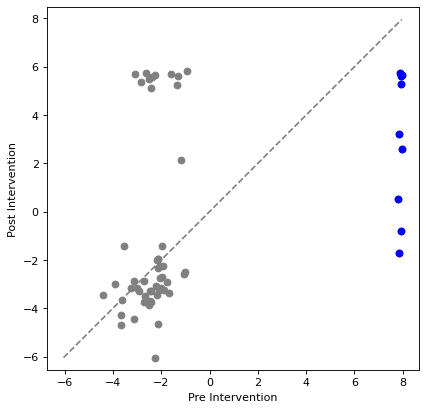

In [129]:
fig, ax = plt.subplots(1, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

x, y = pre_intv_pred[1:], post_intv_pred[1:]

# plotting illegal moves in grey
ax.scatter(x, y, color='grey', zorder=1)
# plotting legal moves as blue
# valid_tokens = [train_dataset.stoi[x] - 1 for x in get_post_intv_board(completion, intvs).get_valid_moves()]
valid_tokens = [train_dataset.stoi[x] - 1 for x in post_intv_board.get_valid_moves()]
ax.scatter(x[valid_tokens], y[valid_tokens], color='blue', zorder=2)

# plotting x=y for context
axis_min = min(min(x), min(y))
axis_max = max(max(x), max(y))
ax.plot([axis_min, axis_max], [axis_min, axis_max], color='grey', linestyle='dashed', zorder=0)

# axis, labels
ax.set_xlabel("Pre Intervention")
ax.set_ylabel("Post Intervention")
ax.axis('equal')

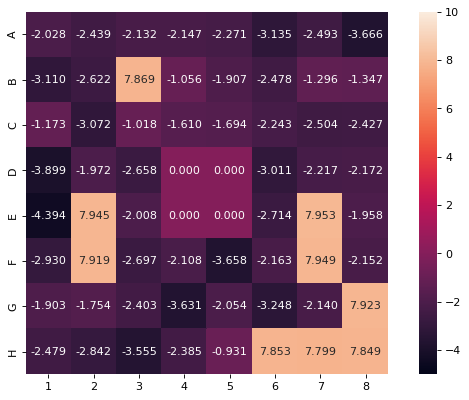

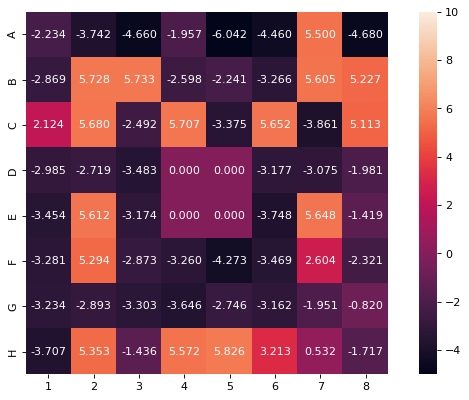

In [130]:
fig = draw_heatmap_from_tokens(pre_intv_pred, vmin=-5, vmax=10)
fig = draw_heatmap_from_tokens(post_intv_pred, vmin=-5, vmax=10)

In [131]:
print([x.shape for x in board_probe_logits])
data = [x.softmax(dim=-1).detach().cpu().numpy() for x in board_probe_logits]
# data = [x[:, [1, 0, 2]] for x in data] # rearranging so order is empty, my color, opp color
print([x.shape for x in data])

[torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([64, 3])]
[(64, 3), (64, 3), (64, 3), (64, 3), (64, 3), (64, 3), (64, 3), (64, 3), (64, 3)]


['1', '2', '3', '4 (pre)', '4 (post)', '5', '6', '7', '8']


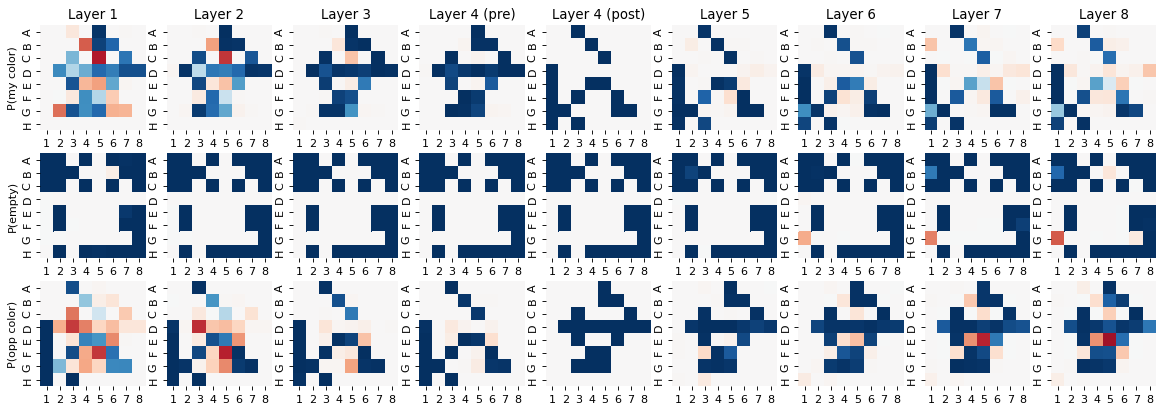

In [132]:
nrows, ncols = 3, len(data)
plot_scale = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * plot_scale, nrows * plot_scale), dpi=80, facecolor='w', edgecolor='k')

i_layer = intervene_layers[0]
true_pre_state = np.array(pre_board.get_state())
true_post_state = np.array(post_intv_board.get_state())

for i in range(len(data)):
    for j in range(3):
        board = data[i][:, j].copy()
        if i < i_layer:
            board[true_pre_state != j] *= -1
        else:
            board[true_post_state != j] *= -1

        sns.heatmap(board.reshape(8, 8), 
                    ax=axs[j][i], 
                    yticklabels=list("ABCDEFGH"), 
                    xticklabels=list(range(1,9)), 
                    square=True, 
                    center=0, vmax=1, vmin=-1,
                    cbar=False,
                    cmap="RdBu")

# setting titles
xticks = [str(x) for x in range(1, 9)]
xticks.insert(i_layer, f"{i_layer} (post)")
xticks.insert(i_layer, f"{i_layer} (pre)")
xticks.remove(str(i_layer))

# setting y axis labels
for i, name in enumerate(xticks):
    ax = axs[0, i]
    ax.set_title(f"Layer {name}")

axs[0, 0].set_ylabel("P(my color)")
axs[1, 0].set_ylabel("P(empty)")
axs[2, 0].set_ylabel("P(opp color)")

print(xticks)
     

### intervening on turn

In [11]:
all_layers = range(1, 9)
models, device = load_model_layers("bias/TLcontrol", all_layers)
board_probes = load_linear_probes("bias/probes/state_control", all_layers)
turn_probes = load_linear_probes("bias/probes/turn_control", all_layers, probe_class=2, num_task=1)

In [12]:
othello = Othello(data_root="othello_synthetic", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)

Mem Used: 3.944 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


In [58]:
completion = othello[0][:11]

pre_board = OthelloBoardState()
pre_board.update(completion)
print("next color:", pre_board.get_next_hand_color())
pre_board.__print__()
print([permit_reverse(x) for x in pre_board.get_valid_moves()])

next color: 0
--------------------
['f5', 'f4', 'g3', 'd6', 'c7', 'f6', 'c5', 'g4', 'h3', 'b6', 'f3']
a                
b           O    
c         O   X  
d       O X X    
e       X X      
f     X X X O    
g     X X        
h     X          
  1 2 3 4 5 6 7 8
--------------------
['d7', 'd8', 'e7', 'f2', 'g5', 'h4']


In [59]:
flipped_turn_board = OthelloBoardState()
flipped_turn_board.update(completion)
flipped_turn_board.next_hand_color *= -1
print("next color:", flipped_turn_board.get_next_hand_color())
flipped_turn_board.__print__()
print([permit_reverse(x) for x in flipped_turn_board.get_valid_moves()])

next color: 1
--------------------
['f5', 'f4', 'g3', 'd6', 'c7', 'f6', 'c5', 'g4', 'h3', 'b6', 'f3']
a                
b           O    
c         O   X  
d       O X X    
e       X X      
f     X X X O    
g     X X        
h     X          
  1 2 3 4 5 6 7 8
--------------------
['a5', 'b4', 'b5', 'c3', 'c4', 'd3', 'f7', 'g7']


In [60]:
def get_probe_goal_state(ob):
    goal_state = [
        [5, -10, -2], # my color
        [-5, 10, -5], # empty
        [-2, -10, 5], # opp color
    ]
    desired_probe_state = np.zeros((64, 3))

    state = np.array(ob.get_state())
    desired_probe_state[state == 0] = goal_state[0]
    desired_probe_state[state == 1] = goal_state[1]
    desired_probe_state[state == 2] = goal_state[2]
    
    return desired_probe_state

In [70]:
i_layers = [1]
scale = 2
desired_probe_state = get_probe_goal_state(flipped_turn_board)

partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)
pre_intv_pred, _ = models[all_layers.stop-1](partial_game[None, :])  # [B, T, F=512]
pre_intv_pred = pre_intv_pred[0, -1, :].detach().cpu().numpy()

# tracking probes across the intervention
saved_turn_probe_logits = []
saved_board_probe_logits = []

for i, current_layer in enumerate(all_layers):
    p = turn_probes[current_layer]

    if i == 0:
        whole_mid_act = models[all_layers.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
    # after starting layer, use forward_2nd_stage to get to next layer
    else:
        whole_mid_act = models[all_layers.start].forward_2nd_stage(whole_mid_act, current_layer-1, current_layer)[0]  # [1, T, F=512]

    # cut out most recent features and check probe prediction
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)
    saved_turn_probe_logits.append(pre_intv_logits)
    saved_board_probe_logits.append(board_probes[current_layer](mid_act[None, :])[0].squeeze(0))

    if current_layer not in i_layers:
        continue

    # make actual intervention on mid activations
    new_mid_act = mid_act.clone()

    # linear steering intervention on turn
    m = p.proj.weight.data
    new_mid_act += m[1] * scale
    new_mid_act -= m[0] * scale

    # pinv = torch.pinverse(board_probes[current_layer].proj.weight.data)  # [512, 192]
    # desired_probe_tensor = torch.from_numpy(desired_probe_state).to(pinv.dtype).to(device)
    # new_mid_act = torch.matmul(pinv, desired_probe_tensor.reshape(192))
    

    post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0) 
    saved_turn_probe_logits.append(post_intv_logits)
    saved_board_probe_logits.append(board_probes[current_layer](new_mid_act[None, :])[0].squeeze(0))

    # swap in 
    whole_mid_act[0, -1] = new_mid_act

post_intv_pred, _ = models[all_layers.start].predict(whole_mid_act)
post_intv_pred = post_intv_pred[0, -1, :].detach().cpu().numpy()

saved_turn_probe_logits = np.array([x.detach().cpu().numpy() for x in saved_turn_probe_logits])
saved_board_probe_logits = np.array([x.softmax(dim=-1).detach().cpu().numpy() for x in saved_board_probe_logits])

In [71]:
for l in saved_turn_probe_logits:
    print(l)

[[ 3.709229  -3.5671678]]
[[-13.374707   13.2729225]]
[[-7.15326   7.348569]]
[[-5.517205  6.025823]]
[[-4.830054  5.585883]]
[[-3.664229  4.633889]]
[[-3.6744273  3.7474585]]
[[-3.8513846  4.537206 ]]
[[-3.217497   3.8057966]]


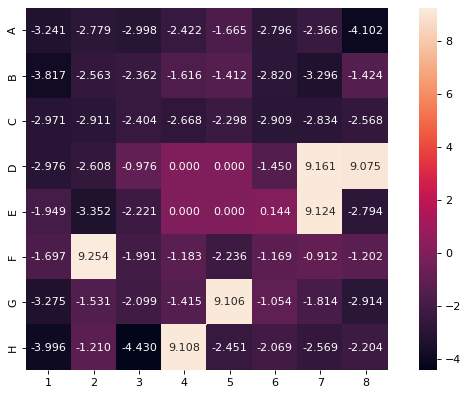

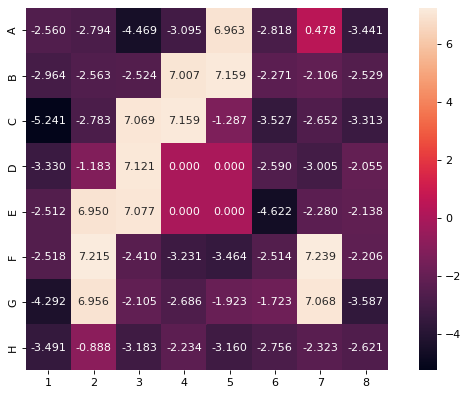

In [72]:
fig = draw_heatmap_from_tokens(pre_intv_pred)
fig = draw_heatmap_from_tokens(post_intv_pred)

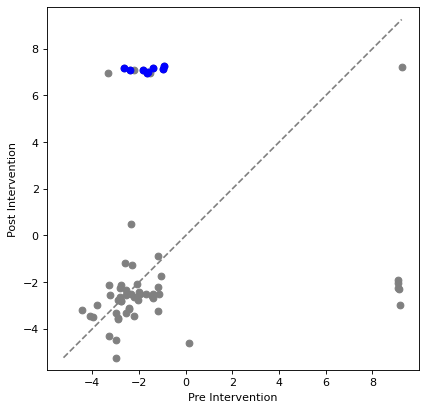

In [73]:
fig, ax = plt.subplots(1, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

x, y = pre_intv_pred[1:], post_intv_pred[1:]

# plotting illegal moves in grey
ax.scatter(x, y, color='grey', zorder=1)
# plotting legal moves as blue
valid_tokens = [train_dataset.stoi[x] - 1 for x in flipped_turn_board.get_valid_moves()]
ax.scatter(x[valid_tokens], y[valid_tokens], color='blue', zorder=2)

# plotting x=y for context
axis_min = min(min(x), min(y))
axis_max = max(max(x), max(y))
ax.plot([axis_min, axis_max], [axis_min, axis_max], color='grey', linestyle='dashed', zorder=0)

# axis, labels
ax.set_xlabel("Pre Intervention")
ax.set_ylabel("Post Intervention")
ax.axis('equal')

plt.show()

In [74]:
def chart_board_probes_over_intervention(data, intv_layer=-1):
    nrows, ncols = 3, len(data)
    plot_scale = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * plot_scale, nrows * plot_scale), dpi=80, facecolor='w', edgecolor='k')

    for i in range(len(data)):
        for j in range(3):
            board = data[i][:, j].copy()

            sns.heatmap(board.reshape(8, 8), 
                        ax=axs[j][i], 
                        yticklabels=list("ABCDEFGH"), 
                        xticklabels=list(range(1,9)), 
                        square=True, 
                        vmax=1, vmin=0,
                        cbar=False,
                        cmap="Blues")

    # setting titles
    xticks = [str(x) for x in range(1, 9)]
    if intv_layer >= 0:
        xticks.insert(intv_layer, f"{intv_layer} (post)")
        xticks.insert(intv_layer, f"{intv_layer} (pre)")
        xticks.remove(str(intv_layer))

    # setting y axis labels
    for i, name in enumerate(xticks):
        ax = axs[0, i]
        ax.set_title(f"Layer {name}")

    axs[0, 0].set_ylabel("P(my color)")
    axs[1, 0].set_ylabel("P(empty)")
    axs[2, 0].set_ylabel("P(opp color)")

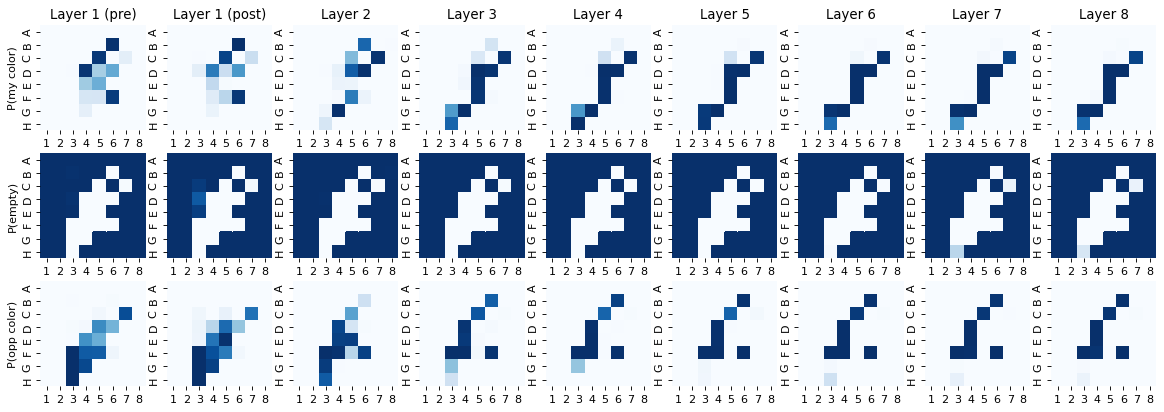

In [75]:
chart_board_probes_over_intervention(saved_board_probe_logits, intv_layer=i_layers[0])

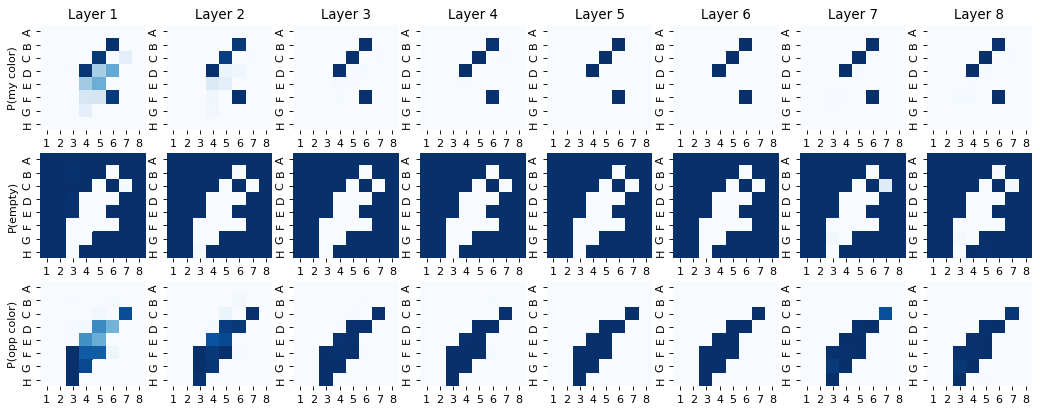

In [76]:
without_intv = [get_probe_logits(models, device, board_probes, l, completion, softmax=True) for l in all_layers]
chart_board_probes_over_intervention(without_intv)